In [10]:
import numpy as np
import tensorflow as tf
from time import gmtime, strftime
import time
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import model
import utils
import cv2
from IPython import display
%matplotlib inline
%matplotlib notebook

In [11]:
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False
    
print(is_capturing)

while is_capturing:
    try:    # Lookout for a keyboardInterrupt to stop the script
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        webcam_preview.set_data(frame)
        plt.draw()

        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.pause(0.1)    # the pause time is = 1 / framerate
    except KeyboardInterrupt:
        vc.release()


False


In [3]:
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

config = type("Foo", (object,), {})()
config.dataset = 'celebA'
config.batch_size = 64

#with tf.Session(config=run_config) as sess:
sess = tf.Session(config=run_config) 
dcgan = model.DCGAN(
    sess,
    input_height=108,
    input_width=108,
    output_width=64,
    output_height=64,
    batch_size=config.batch_size,
    sample_num=64,
    dataset_name='celebA',
    input_fname_pattern='*.jpg',
    crop=True, #true for training
    checkpoint_dir='checkpoint',
    sample_dir='samples'
)

if not dcgan.load('checkpoint')[0]:
    print('Cannot find checkpoint!')

utils.show_all_variables()


 [*] Reading checkpoints...
 [*] Success to read DCGAN.model-32502
---------
Variables: name (type shape) [size]
---------
generator/g_h0_lin/Matrix:0 (float32_ref 100x8192) [819200, bytes: 3276800]
generator/g_h0_lin/bias:0 (float32_ref 8192) [8192, bytes: 32768]
generator/g_bn0/beta:0 (float32_ref 512) [512, bytes: 2048]
generator/g_bn0/gamma:0 (float32_ref 512) [512, bytes: 2048]
generator/g_h1/w:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
generator/g_h1/biases:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/beta:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/gamma:0 (float32_ref 256) [256, bytes: 1024]
generator/g_h2/w:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
generator/g_h2/biases:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/beta:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/gamma:0 (float32_ref 128) [128, bytes: 512]
generator/g_h3/w:0 (float32_ref 5x5x64x128) [204800, bytes: 819200]
generator/g_h3/biases:0 (float32_ref 64) [6

In [4]:
def get_mask(file):
    image = imread(file)
    a = image[:,:,0]
    b = a/np.max(a)
    c = np.rint(b)
    return c

def deprocess_image(img):
    return np.clip(255 * (img+0.5), 0.0, 255.0).astype(np.uint8)


In [5]:
z_sample = np.random.uniform(-0.5, 0.5, size=(config.batch_size, dcgan.z_dim))

In [15]:
"""
z_mask = np.ones([dcgan.z_dim]) # 100
h0_mask = np.ones([dcgan.gf_dim*8]) # 512 
h1_mask = np.ones([dcgan.gf_dim*4]) # 256
h2_mask = np.ones([dcgan.gf_dim*2]) # 128 
h3_mask = np.ones([dcgan.gf_dim*1]) # 64
h4_mask = np.ones([dcgan.c_dim]) # 3
"""
z_mask = np.ones([dcgan.z_dim])
z_mask = np.reshape(get_mask('./masks/mask10.png'), (-1))
h0_mask = np.ones([dcgan.output_height/16, dcgan.output_width/16]) # 4, 4
h1_mask = np.ones([dcgan.output_height/8, dcgan.output_width/8]) # 8, 8
h2_mask = np.ones([dcgan.output_height/4, dcgan.output_width/4]) # 16, 16
h3_mask = np.ones([dcgan.output_height/2, dcgan.output_width/2]) # 32, 32
h4_mask = np.ones([dcgan.output_height, dcgan.output_width]) # 64, 64


# z_mask = np.reshape(get_mask('./masks/mask10person.png'), (-1))
#z_mask = np.reshape(get_mask('./masks/mask10.png'), (-1))
h0_mask = get_mask('./masks/mask4.png')
#h1_mask = get_mask('./masks/mask8.png')
#h2_mask = get_mask('./masks/mask16.png')
#h3_mask = get_mask('./masks/mask32.png')
#h4_mask = get_mask('./masks/mask64.png')



feed_dict = {
    dcgan.z: z_sample, 
    dcgan.z_mask: z_mask,
    dcgan.h0_mask: h0_mask,
    dcgan.h1_mask: h1_mask,
    dcgan.h2_mask: h2_mask,
    dcgan.h3_mask: h3_mask,
    dcgan.h4_mask: h4_mask,
}

print(int(round(time.time() * 1000)))
samples = sess.run(dcgan.sampler, feed_dict=feed_dict)
print(int(round(time.time() * 1000))) # about 60ms on gpu to run 
utils.save_images(samples, [8,8], './samples/test_%s.png' % strftime("%Y%m%d%H%M%S", gmtime()))


1496961006593
1496961006649


(64, 64, 64, 3)


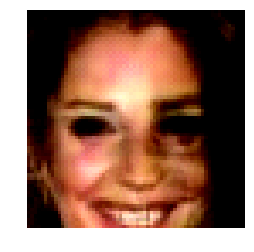

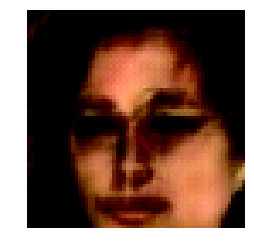

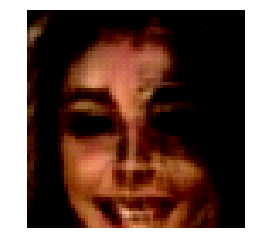

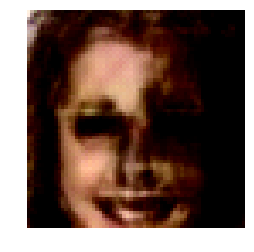

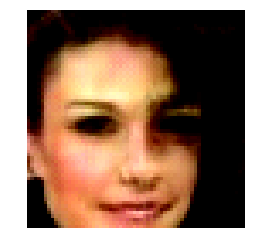

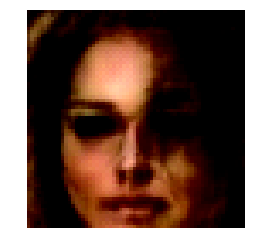

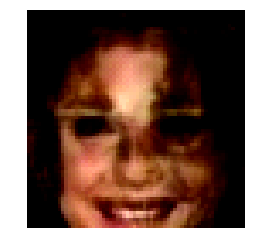

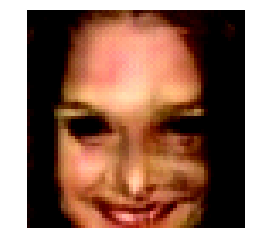

In [7]:
print(samples.shape)
for image in samples[:8]:
    plt.imshow(deprocess_image(image))
    plt.axis('off')
    plt.show()